In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
# read file
def read_dat(file_path):

    temp = []
    MSD = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line_num, line in enumerate(lines, start=1):
            if not line.startswith('#') and not line.startswith('@') and line.strip():
                parts = line.split()
                if len(parts) >= 2:  # Ensure there are at least two values
                    try:
                        temp.append(float(parts[0]))
                        MSD.append(float(parts[1]))
                    except ValueError as e:
                        print(f"Error converting line {line_num}: {line.strip()} -> {e}")
                else:
                    print(f"Skipping malformed line {line_num}: {line.strip()}")

    return np.array(temp), np.array(MSD)

temp, MSD = read_dat('temp_vs_500.dat')

In [5]:
# only need 800-100K for MSD
temp_800_onwards = temp[19:]  
MSD_800_onwards = MSD[19:]

low_temp_mask = temp_800_onwards <= 300  # low temp regime
high_temp_mask = temp_800_onwards >= 590  # high temp regime

In [7]:
def hyperbolic_fit(T, r0, a, b, T0, c):
    H0 = 0.5 * ((T - T0) + np.sqrt((T - T0)**2 + 4 * np.exp(c)))
    return r0 + a * (T - T0) + b * H0

# initial guesses
initial_guess = [2, 0.005, 0.1, 400, 0]  # Adjusted initial guess
bounds = ([0, 0, 0, 100, -10], [3, 0.1, 1, 800, 10])

# hyperbola
popt, pcov = curve_fit(hyperbolic_fit, temp_800_onwards, MSD_800_onwards, p0=initial_guess, bounds=bounds, maxfev=10000)

r0, a, b, T0, c = popt

# fitted MSD and error
p_fit = hyperbolic_fit(temp_800_onwards, *popt)
errors = np.sqrt(np.diag(pcov))

T0 = popt[3]  # fitted tg
T0_error = errors[3]  # tg error

# r^2 for fitting
r_squared = r2_score(MSD_800_onwards, p_fit)

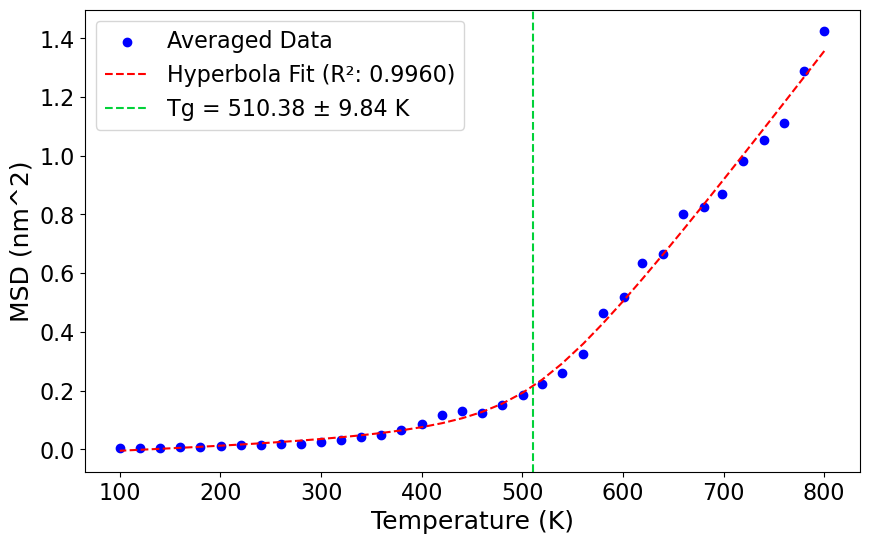

In [11]:
# plot graph
plt.figure(figsize=(10, 6))
plt.scatter(temp_800_onwards, MSD_800_onwards, label='Averaged Data', color='blue') # data
plt.plot(temp_800_onwards, p_fit, label=f'Hyperbola Fit (R²: {r_squared:.4f})', color='red', linestyle='--') # hyperbolic fit
plt.axvline(x=T0, color='#02d139', linestyle='--', label=f'Tg = {T0:.2f} ± {T0_error:.2f} K') # intersection shows tg

plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel('MSD (nm^2)', fontsize=18)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()